## Common Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights
from torchvision.models import swin_b
from torchvision.models import Swin_B_Weights
import datetime
import math
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train = h5py.File('../rec1501614399_export.hdf5', 'r')
test = h5py.File('../rec1501612590_export.hdf5', 'r')

In [ ]:
window_size = 10

In [ ]:
classifier = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
classifier.heads = nn.Identity()
"""
classifier = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
classifier.classifier = nn.Identity()
"""


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 186MB/s]


'\nclassifier = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)\nclassifier.classifier = nn.Identity()\n'

In [ ]:
classifier.to(device)
classifier.eval()
print("done")

done


In [ ]:
img_transforms = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

## Concept differentiation: Image and sensor data are different things

In [ ]:
"""
select n_heads, and d_model. d_model must be multiple of n_heads.
"""
n_heads = 8
d_model = 160 #20 * n_heads

In [3]:
img_repr_dim = 768
class PolicyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.sep = -1 * torch.ones(d_model, dtype=torch.float32,
                               device = device).unsqueeze(0)
    self.img_ffn = nn.Sequential(
        nn.Linear(img_repr_dim, d_model),
        nn.ReLU()
    )
    self.sensor_ffn = nn.Sequential(
        nn.Linear(3, d_model),
        nn.ReLU()
    )
    self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)

    # only taking the attention score for the last sensors timestamp
    self.head = nn.Sequential(
        nn.Linear(d_model, 3),
        nn.Sigmoid()
    )


  def forward(self, imgs, sensors, img_enc=None, sens_enc=None):
    imgs = self.img_ffn(imgs)
    sensors = self.sensor_ffn(sensors)
    imgs_encoded = imgs.clone().detach()
    sensors_encoded = sensors.clone().detach()

    # apply encoding, if needed
    if img_enc is not None:
      for idx in range(len(imgs)):
        imgs_encoded[idx] = imgs[idx].add(img_enc[idx])
    if sens_enc is not None:
      for idx in range(len(sensors)):
        sensors_encoded[idx] = sensors[idx].add(sens_enc[idx])

    x = torch.cat((imgs_encoded, self.sep, sensors_encoded), dim=0)
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [ ]:
policyNet=PolicyNet()
policyNet.to(device)
print("done")

done


In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(policyNet.parameters(), lr=0.01)

In [ ]:
%%time

alpha = 0.2
beta = 2
brake_old = None
num_epochs = 1
losses = []
for epoch in range(num_epochs):
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(train["aps_frame"])):

    # getting i-th frame representation
    img = np.flip(train["aps_frame"][i])
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    with torch.no_grad():
      output = classifier(img)
      output = output.squeeze(0) #output is already on device

    sensors = [train['accelerator_pedal_position'][i]/100,
                  train['brake_pedal_status'][i],
                  (train['steering_wheel_angle'][i]+600)/1200]


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    optimizer.zero_grad()

    loss = criterion(output, sensors_queue_tensor[-1])
    # outliers prevention
    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    if(output.shape != sensors_queue_tensor[-1].shape):
      print(output.shape, sensors_queue_tensor[-1].shape)
      break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)
  print(f"done epoch {epoch}.")

1000
2000
3000
4000
5000
6000
7000
8000
done epoch 0.
CPU times: user 2min 32s, sys: 1.16 s, total: 2min 33s
Wall time: 2min 37s


0.018681712747144204


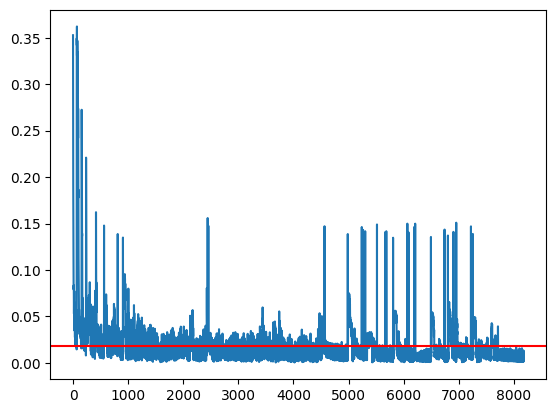

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

In [ ]:
%%time

policyNet.eval()
losses = []
predictions = []
with torch.no_grad():
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(test["aps_frame"])):

    # getting i-th frame representation
    img = np.flip(test["aps_frame"][i])
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    with torch.no_grad():
      output = classifier(img)
      output = output.squeeze(0) #output is already on device

    sensors = [test['accelerator_pedal_position'][i]/100,
                  test['brake_pedal_status'][i],
                  (test['steering_wheel_angle'][i]+600)/1200]


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    loss = criterion(output, sensors_queue_tensor[-1])

    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    predictions.append(output.tolist())

    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)
  print(f"done epoch {epoch}.")

1000
2000
3000
4000
5000
6000
7000
8000
done epoch 0.
CPU times: user 2min 18s, sys: 734 ms, total: 2min 19s
Wall time: 2min 22s


avg loss: 0.02967439751609935
max loss: 0.271328866481781
min loss: 0.0005196942947804928
[0.0006398322875611484, 0.9991394281387329, 0.49968382716178894]


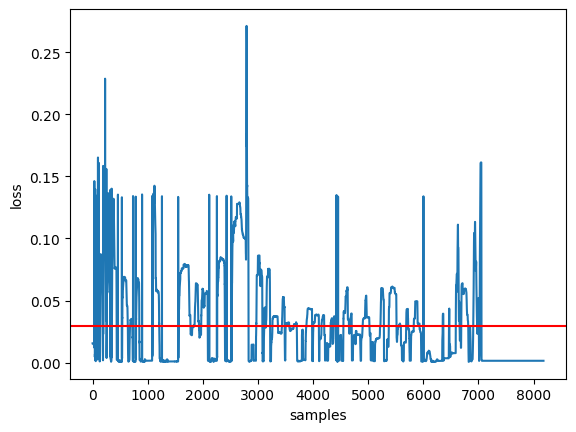

In [ ]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")
print(predictions[0])

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

In [ ]:
img_repr_dim = 1024

In [ ]:
class PolicyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.sep = -1 * torch.ones(d_model, dtype=torch.float32,
                               device = device).unsqueeze(0)
    self.img_ffn = nn.Sequential(
        nn.Linear(img_repr_dim, d_model),
        nn.ReLU()
    )
    self.sensor_ffn = nn.Sequential(
        nn.Linear(3, d_model),
        nn.ReLU()
    )
    self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)

    # only taking the attention score for the last sensors timestamp
    self.head = nn.Sequential(
        nn.Linear(d_model, 3),
        nn.Sigmoid()
    )


  def forward(self, imgs, sensors, img_enc=None, sens_enc=None):
    imgs = self.img_ffn(imgs)
    sensors = self.sensor_ffn(sensors)
    imgs_encoded = imgs.clone().detach()
    sensors_encoded = sensors.clone().detach()

    # apply encoding, if needed
    if img_enc is not None:
      for idx in range(len(imgs)):
        imgs_encoded[idx] = imgs[idx].add(img_enc[idx])
    if sens_enc is not None:
      for idx in range(len(sensors)):
        sensors_encoded[idx] = sensors[idx].add(sens_enc[idx])

    x = torch.cat((imgs_encoded, self.sep, sensors_encoded), dim=0)
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [ ]:
policyNet=PolicyNet()
policyNet.to(device)
print("done")

done


In [ ]:
classifier = swin_b(weights=Swin_B_Weights.IMAGENET1K_V1)
classifier.head = nn.Identity()
classifier.to(device)
print("done")

Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:02<00:00, 138MB/s]


done


In [ ]:
img_transforms = Swin_B_Weights.IMAGENET1K_V1.transforms()

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(policyNet.parameters(), lr=0.01)

In [ ]:
%%time

alpha = 0.2
beta = 2
brake_old = None
num_epochs = 1
losses = []
for epoch in range(num_epochs):
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(train["aps_frame"])):

    # getting i-th frame representation
    img = np.flip(train["aps_frame"][i])
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    with torch.no_grad():
      output = classifier(img)
      output = output.squeeze(0) #output is already on device

    sensors = [train['accelerator_pedal_position'][i]/100,
                  train['brake_pedal_status'][i],
                  (train['steering_wheel_angle'][i]+600)/1200]


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    optimizer.zero_grad()

    loss = criterion(output, sensors_queue_tensor[-1])
    # outliers prevention
    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    if(output.shape != sensors_queue_tensor[-1].shape):
      print(output.shape, sensors_queue_tensor[-1].shape)
      break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)
  print(f"done epoch {epoch}.")

1000
2000
3000
4000
5000
6000
7000
8000
done epoch 0.
CPU times: user 5min 10s, sys: 1.42 s, total: 5min 11s
Wall time: 5min 13s


0.019736498692686448


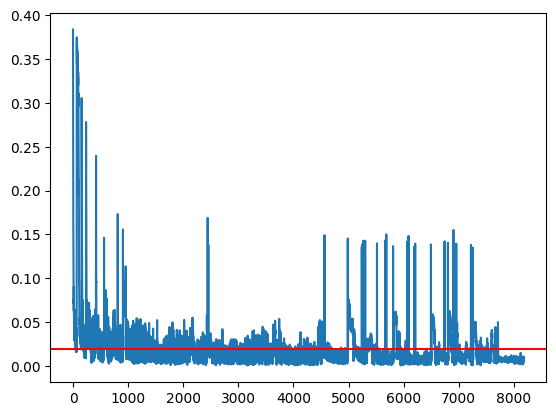

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

In [ ]:
%%time

policyNet.eval()
losses = []
predictions_swin = []
with torch.no_grad():
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(test["aps_frame"])):

    # getting i-th frame representation
    img = np.flip(test["aps_frame"][i])
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    with torch.no_grad():
      output = classifier(img)
      output = output.squeeze(0) #output is already on device

    sensors = [test['accelerator_pedal_position'][i]/100,
                  test['brake_pedal_status'][i],
                  (test['steering_wheel_angle'][i]+600)/1200]


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(output.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    loss = criterion(output, sensors_queue_tensor[-1])

    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    predictions_swin.append(output.tolist())

    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)
  print(f"done epoch {epoch}.")

1000
2000
3000
4000
5000
6000
7000
8000
done epoch 0.
CPU times: user 4min 53s, sys: 1.04 s, total: 4min 54s
Wall time: 4min 55s


avg loss: 0.034756543538277326
max loss: 0.28788483142852783
min loss: 0.0006573358550667763


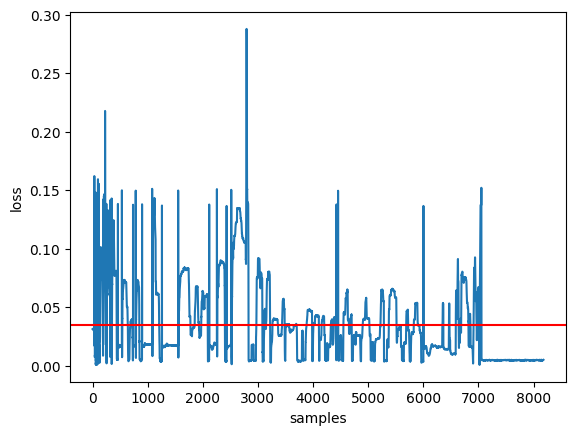

In [ ]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

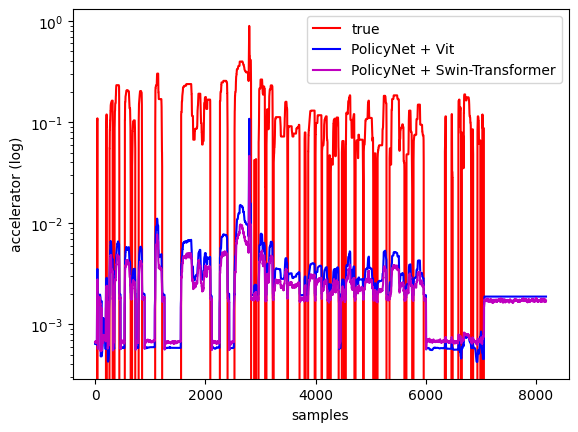

In [ ]:
accelerations = [element[0] for element in predictions]
accelerations_swin = [element[0] for element in predictions_swin]
truth = test['accelerator_pedal_position'][window_size-1:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='PolicyNet + Vit')
plt.plot(accelerations_swin, color='m', label='PolicyNet + Swin-Transformer')
plt.xlabel('samples')
plt.ylabel('accelerator (log)')
plt.yscale('log')
plt.legend()
plt.savefig('acc_1_ep.png')
plt.show()

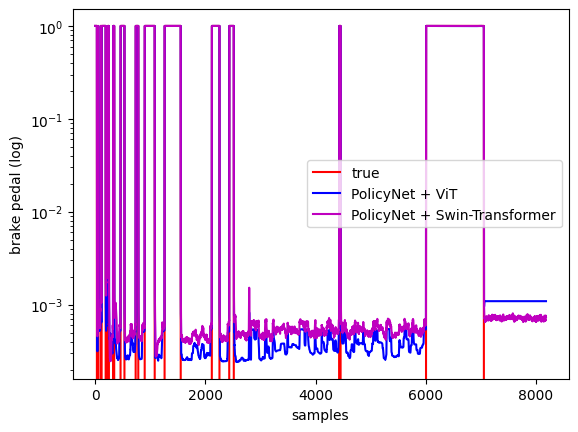

In [ ]:
brakes = [element[1] for element in predictions]
brakes_swin = [element[1] for element in predictions_swin]
truth = test['brake_pedal_status'][window_size-1:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='PolicyNet + ViT')
plt.plot(brakes_swin, color='m', label='PolicyNet + Swin-Transformer')
plt.xlabel('samples')
plt.ylabel('brake pedal (log)')
plt.yscale('log')
plt.legend()
plt.savefig('brk_1_ep.png')
plt.show()

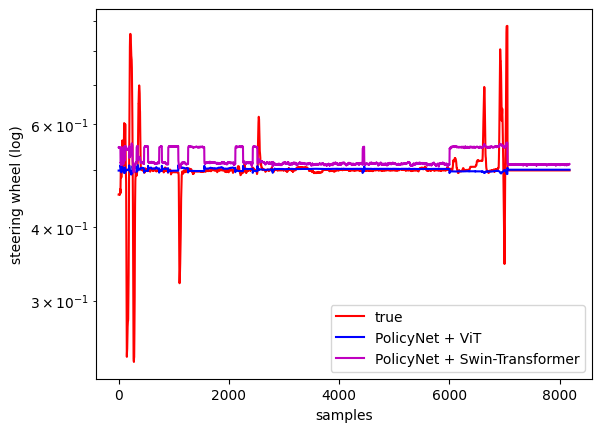

In [ ]:
steers = [element[2] for element in predictions]
steers_swin = [element[2] for element in predictions_swin]
truth = test['steering_wheel_angle'][window_size-1:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth, color='r', label='true')
plt.plot(steers, color='b', label='PolicyNet + ViT')
plt.plot(steers_swin, color='m', label='PolicyNet + Swin-Transformer')
plt.xlabel('samples')
plt.ylabel('steering wheel (log)')
plt.legend()
plt.yscale('log')
plt.savefig('str_1_ep.png', bbox_inches="tight")
plt.show()

In [ ]:
predictions_tensor=torch.tensor(predictions, dtype=torch.float32)
predictions_tensor_swin=torch.tensor(predictions_swin, dtype=torch.float32)
torch.save(predictions_tensor, "./policynet_pred.pt")
torch.save(predictions_swin_tensor, "./policynet_swin_pred.pt")